In [1]:
from astropy.table import Table, Column, table, vstack, setdiff
from pathlib import Path

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation

In [2]:
path_raw='../Datos/Raw/'
path_phot_ned = '../Datos/Work/Phot_Tables_NED/' #In this path wi will save the photometry tables for each object
path_phot_cds = '../Datos/Work/Phot_Tables_CDS/'
path_SED = '../Datos/Work/SEDs/'
path_CIGALE_phot = '../Datos/Work/CIGALE_InputPhot/'
path_CIGALE_out = '../Datos/Work/CIGALE_Output/'
path_graphs = '../Datos/Final/Graphics/'
path_FINAL = '../Datos/Final/'

out = ['/out_0a90/','/out_30y70/']

## Joinig the results from CIGALE of each group 

Read and join all the results of CIGALE of each group:
- **out_0a90:** Are the results for the setup **pcigale.ini** with skirtor2016 parameters of i = 0 to 90 in steps of 10 and oa = 40
- **out_30y70:** Are the results for the setup **pcigale.ini** with skirtor2016 parameters of i = 30 and 70 in steps and oa = 10, 40 and 70

Number of galaxys in group 1 :  117
Number of galaxys in group 2 :  59
Number of galaxys in group 3 :  25
Number of galaxys in group 4 :  8
Number of galaxys in group 5 :  9
Number of galaxys in group 6 :  17
Number of galaxys in group 7 :  6
Number of galaxys in group 8 :  4
Number of galaxys in group 9 :  3
Number of galaxys in group 10 :  4
Total galaxys:  252


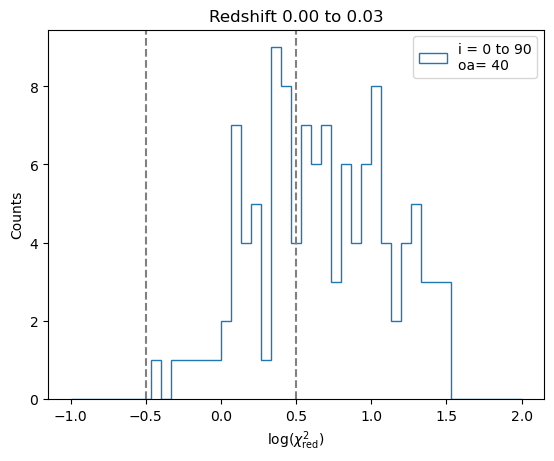

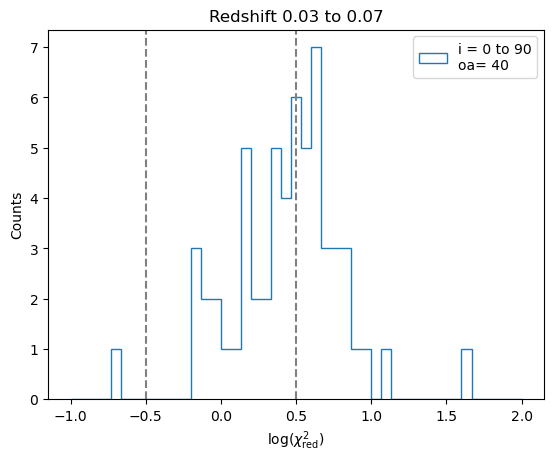

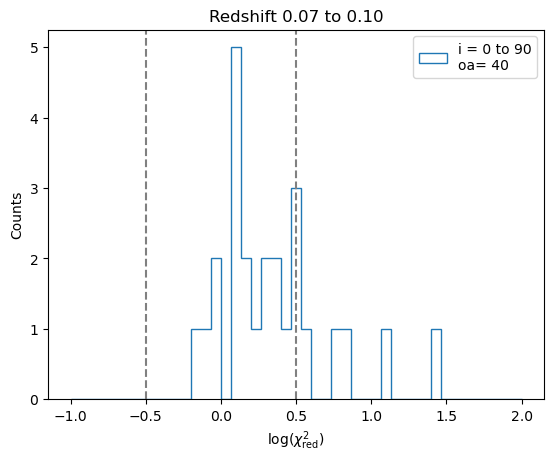

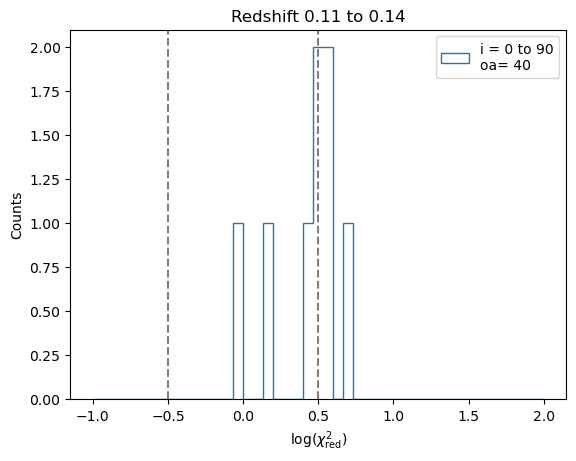

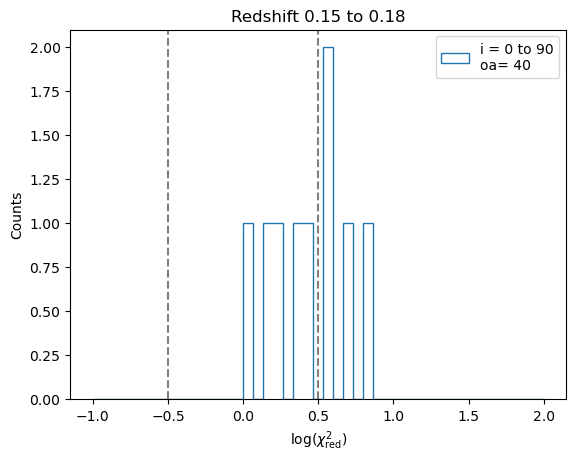

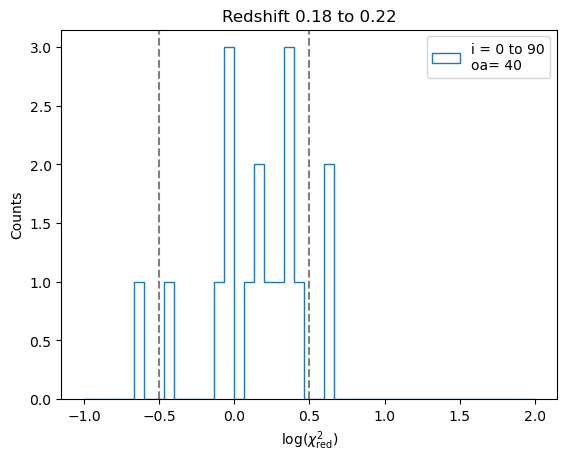

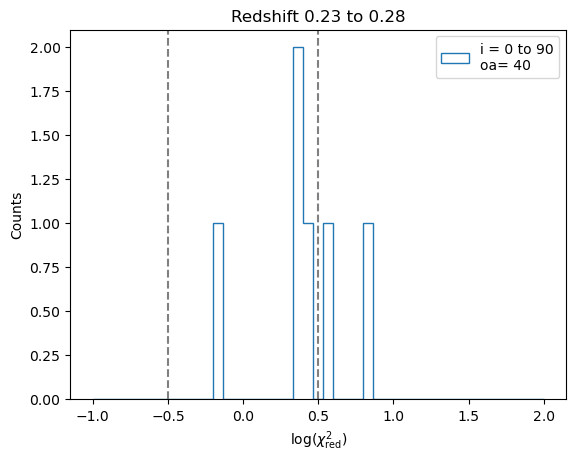

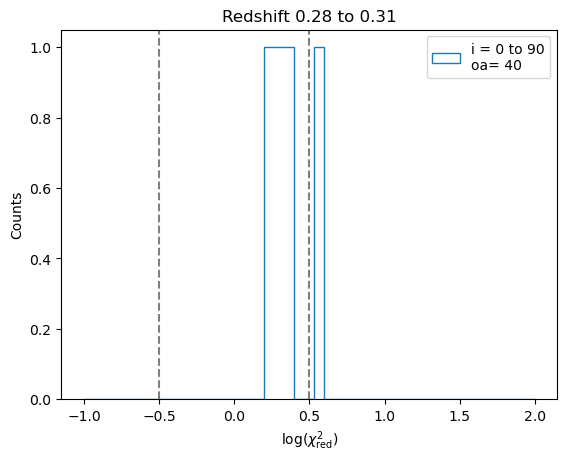

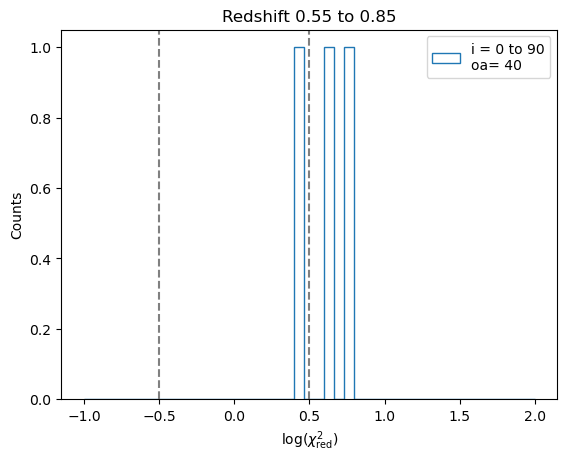

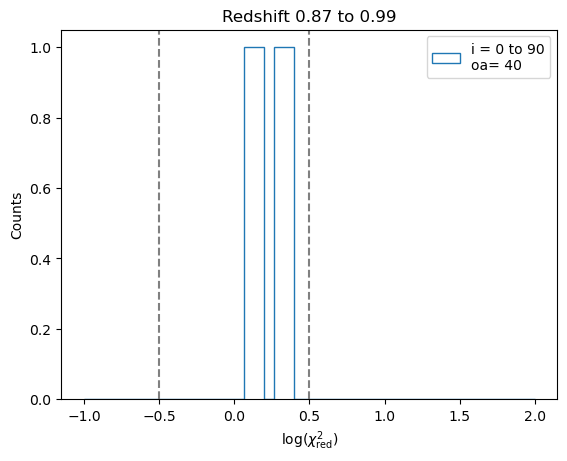

In [4]:
out0to90 = Table()
out30and70 = Table()
redshift_ranges = ['0.00 to 0.03','0.03 to 0.07','0.07 to 0.10','0.11 to 0.14',\
                   '0.15 to 0.18','0.18 to 0.22','0.23 to 0.28','0.28 to 0.31',\
                   '0.55 to 0.85','0.87 to 0.99']

for i in range(10):
    CIGPhotIn = Table()
    out0090 = Table()
    out3070 = Table()
    CIGPhotIn = Table.read(path_CIGALE_phot+'CIGPhot_EnergyBal_'+str(i+1)+'.tbl', format='ascii')
    out0090 = Table.read(path_CIGALE_out+'Group_'+str(i+1)+out[0]+'results.fits',format='fits')
    #out3070 = Table.read(path_CIGALE_out+'Group_'+str(i+1)+out[1]+'results.fits',format='fits')
    
    out0090['log.reduced_chi_square'] = np.log10(out0090['best.reduced_chi_square'])
    #out3070['log.reduced_chi_square'] = np.log10(out3070['best.reduced_chi_square'])
    
    binsChiS = np.linspace(-1.0, 2.0, 46)  # Assuming ChiSquare bins in this ranges
    fig, axs = plt.subplots(1)
    h1 = plt.hist(out0090['log.reduced_chi_square'], bins=binsChiS, histtype='step',\
                  label='i = 0 to 90\noa= 40')
    #h2 = plt.hist(out3070['log.reduced_chi_square'], bins=binsChiS, histtype='step',\
                  #label='i = 30 and 70\noa = 10, 40 and 70')
    plt.axvline(x=-0.5,ls='--',color='gray')
    plt.axvline(x=0.5,ls='--',color='gray')
    plt.title('Redshift '+redshift_ranges[i])
    plt.xlabel(r'$\log(\chi^2_{\rm{red}})$')
    plt.ylabel('Counts')
    plt.legend()
    plt.savefig(path_graphs+'histo_CIGALE_fitting_group'+str(i+1)+'.jpg')
    
    print('Number of galaxys in group',i+1,': ',len(out0090))
    
    out0to90 = vstack([out0090, out0to90]) #Join all the result tables from CIGALE
    #out30and70 = vstack([out3070, out30and70]) #Join all the result tables from CIGALE

print('Total galaxys: ',len(out0to90))

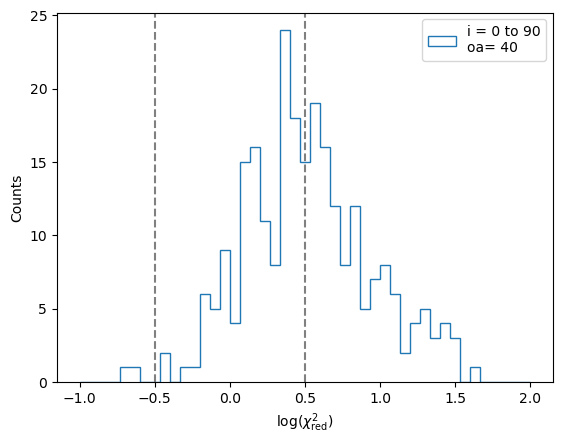

In [5]:
binsChiS = np.linspace(-1.0, 2.0, 46)  # Assuming ChiSquare bins in this ranges
plt.hist(out0to90['log.reduced_chi_square'], bins=binsChiS, histtype='step',\
         label='i = 0 to 90\noa= 40')
#plt.hist(out30and70['log.reduced_chi_square'], bins=binsChiS, histtype='step',\
         #label='i = 30 and 70\noa = 10, 40 and 70')
plt.axvline(x=-0.5,ls='--',color='gray')
plt.axvline(x=0.5,ls='--',color='gray')
plt.xlabel(r'$\log(\chi^2_{\rm{red}})$')
plt.ylabel('Counts')
plt.legend()
plt.savefig(path_graphs+'histo_CIGALE_fitting.jpg')

In [5]:
diff_models = out0to90['best.reduced_chi_square'] - out30and70['best.reduced_chi_square']
print(r'Average difference between reduced chi-square:', 
      np.round(np.mean(np.abs(diff_models)), 3))

Average difference between reduced chi-square: 0.614


## Cleaning the results from CIGALE

Now we are goint to remove the galaxies with bad fittings: $\chi_{\rm{red}}^{2}$ higher than $10^{0.5}$ (Underestimated) and lower than $10^{-0.5}$ (Overestimated).

Re-order the two tables by id according the general table from the input data of CIGALE (Notebook 4):

In [6]:
Phot = Table.read(path_FINAL+'CIGPhot_EnergyBal_All.tbl', format='ascii')
Nbands = [sum(~np.isnan(list(row)[2::2])) for row in Phot]
out0to90 = out0to90[np.concatenate([np.where(out0to90['id'] == oid)[0] for oid in Phot['id']])]
#out30and70 = out30and70[np.concatenate([np.where(out30and70['id'] == oid)[0] for oid in Phot['id']])]

In [9]:
out0to90_clean = out0to90[np.logical_and.reduce([out0to90['best.reduced_chi_square'] <= 10**0.5, \
                                            out0to90['best.reduced_chi_square'] >= 10**-0.5])]

#out30and70_clean = out30and70[np.logical_and.reduce([out30and70['best.reduced_chi_square'] <= 10**0.5, \
                                            #out30and70['best.reduced_chi_square'] >= 10**-0.5])]

Number of galaxies removed after the cleaining

In [10]:
removed_galaxies_1 = len(out0to90)-len(out0to90_clean)
#removed_galaxies_2 = len(out30and70)-len(out30and70_clean)
print('The number of galaxies removed in out0to90 are:',removed_galaxies_1)
#print('The number of galaxies removed in out30and70:',removed_galaxies_2)

The number of galaxies removed in out0to90 are: 123


In [11]:
out0to90_clean = out0to90_clean[np.concatenate([np.where(out0to90_clean['id'] == oid)[0] for oid in Phot['id']])]
#out30and70_clean = out30and70_clean[np.concatenate([np.where(out30and70_clean['id'] == oid)[0] for oid in Phot['id']])]
out0to90_clean.write(path_CIGALE_out+'results0a90_All.fits', format='fits',overwrite=True)
out0to90_clean.write(path_CIGALE_out+'results0a90_All.txt', format='ascii',overwrite=True)
#out30and70_clean.write(path_CIGALE_out+'results30y70_All.fits', format='fits',overwrite=True)
#out30and70_clean.write(path_CIGALE_out+'results30y70_All.txt', format='ascii',overwrite=True)
out0to90_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.sfh.sfr','bayes.sfh.sfr_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square
,,,solMass / yr,solMass / yr,deg,deg,
bytes24,float64,float64,float64,float64,float64,float64,float64
3C 234.0,0.8034799514202404,0.05075017016454414,35.95897699663074,10.767347614953854,63.91729158454189,4.881367022531865,2.5104372093516596
2MASS J13000535+1632148,0.8997482762713642,0.0035397704007171173,0.5592751145937703,0.3523226196938686,60.00022899305476,0.047852752121327925,2.9185132854550697
NGC 262,0.8311068063268808,0.03429833704017644,0.41262349283557975,0.08193771792751078,60.353817806670925,2.5526644023994867,2.7271950294763996
IRAS 04385-0828,0.8377533360368383,0.06730830419243483,0.6844996795586241,0.41201421991957277,70.32589149419321,1.8647530604544669,1.2743039230362945
LEDA 45656,0.8472870737262286,0.011390816329853481,5.68208688272829,3.1546844345510996,33.44539141414346,8.014410726190423,2.2629677066531206
Mrk 1239,0.8286637013421809,0.025625946890626614,1.0983007559520899,0.7300468426918667,50.00000000001281,1.1295948785109648e-05,0.6785526532635565
LEDA 89032,0.6269860211415561,0.09686845515404878,8.847173816801806,5.4804467927366876,21.910700836871282,15.92522582663009,1.4405705818018235
LEDA 3095998,0.1274444596594598,0.05632674800417101,0.7495806753401292,0.21809745566192315,48.18591064655329,27.79066687353976,0.8981715752631481


## Notebook Info

In [10]:
%reload_ext watermark
%watermark -a "Jonhatan Bernal" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astropy

Author: Jonhatan Bernal

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 7.31.1

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.15.0-52-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astropy: 5.1

matplotlib: 3.5.2
numpy     : 1.21.5
astropy   : 5.1

Watermark: 2.3.1



In [11]:
#out30and70_clean['id','bayes.agn.fracAGN','bayes.agn.fracAGN_err','bayes.agn.i','bayes.agn.i_err','best.reduced_chi_square']

id,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.agn.i,bayes.agn.i_err,best.reduced_chi_square
,,,deg,deg,
bytes26,float64,float64,float64,float64,float64
3C 234.0,0.7897734624662449,0.05315868844358782,30.16444893815179,2.559475351085052,1.7771688697829493
2MASS J13000535+1632148,0.8963148198372951,0.013161857660885743,30.00012251383662,0.07000384600057444,2.537620692999024
LEDA 45656,0.8481263011004555,0.009511437616637705,30.000000000000014,1.811535642071679e-14,2.3613368705354025
LEDA 89032,0.7067757493623014,0.10679019919973055,30.00000655376559,0.016191064884239,2.153963766135841
LEDA 3095998,0.15128883664389944,0.08270899195794883,43.98501219814593,19.074064111865255,0.33114812911182423
LEDA 89511,0.8001582554121175,0.006251875518187314,30.000053077180095,0.04607693985296838,1.7024976163507204
Mrk 493,0.5066810842611305,0.06275785220824578,30.011532786504375,0.6791012111683961,1.4733915470782668
2MASS J22255427+1958370,0.7587580279265775,0.11567840272574531,30.17679930176091,2.6534343928825517,0.7664599072552156
